#1. 데이터 전처리
    

*   2019년 7월 이후, 2020년 9월 이후 모든 변수의 값이 NAN -> 제외하고 분석
*   변수 측정 주기, 결측값의 분포와 특정 패턴 분석

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 파일 경로 설정 및 데이터 로드
file_path = '/content/내부to생산량_2019_2020_clean.xlsx'
data = pd.read_excel(file_path)

print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9072 entries, 0 to 9071
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MSRM_DT          9072 non-null   datetime64[ns]
 1   INNER_TPRT       8939 non-null   float64       
 2   INNER_HMDT       8454 non-null   float64       
 3   INNER_CBDX_CTRN  6456 non-null   float64       
 4   SHPMN_QTY        2640 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 354.5 KB
None
              MSRM_DT  INNER_TPRT  INNER_HMDT  INNER_CBDX_CTRN  SHPMN_QTY
0 2019-01-01 00:00:00        19.1        87.0              NaN        NaN
1 2019-01-01 01:00:00        18.8        87.0              NaN        NaN
2 2019-01-01 02:00:00        18.5        87.0              NaN        NaN
3 2019-01-01 03:00:00        18.1        87.0              NaN        NaN
4 2019-01-01 04:00:00        17.8        88.0              NaN        NaN


In [ ]:
print(data)

                 MSRM_DT  INNER_TPRT  INNER_HMDT  INNER_CBDX_CTRN  SHPMN_QTY
0    2019-01-01 00:00:00        19.1        87.0              NaN        NaN
1    2019-01-01 01:00:00        18.8        87.0              NaN        NaN
2    2019-01-01 02:00:00        18.5        87.0              NaN        NaN
3    2019-01-01 03:00:00        18.1        87.0              NaN        NaN
4    2019-01-01 04:00:00        17.8        88.0              NaN        NaN
...                  ...         ...         ...              ...        ...
9067 2020-08-17 19:00:00         NaN         NaN              NaN      270.0
9068 2020-08-17 20:00:00         NaN         NaN              NaN      270.0
9069 2020-08-17 21:00:00         NaN         NaN              NaN      270.0
9070 2020-08-17 22:00:00         NaN         NaN              NaN      270.0
9071 2020-08-17 23:00:00         NaN         NaN              NaN      270.0

[9072 rows x 5 columns]


In [ ]:
# 1. 결측값 개수 및 비율 확인
missing_values_summary = data.isnull().sum()

print("각 열의 결측값 개수:\n", missing_values_summary)

각 열의 결측값 개수:
 MSRM_DT               0
INNER_TPRT          133
INNER_HMDT          618
INNER_CBDX_CTRN    2616
SHPMN_QTY          6432
dtype: int64


In [ ]:
# 4. 연속적인 결측 구간 분석
# 연속된 결측값 개수 확인 (예: 결측값이 연속으로 몇 개 존재하는지)
consecutive_missing = data[['INNER_TPRT', 'INNER_HMDT', 'INNER_CBDX_CTRN', 'SHPMN_QTY']].isnull().astype(int).groupby(data['MSRM_DT'].diff().dt.total_seconds().ne(3600).cumsum()).cumsum()
consecutive_missing_count = consecutive_missing[consecutive_missing > 1].dropna(how='all')
print("연속적인 결측 구간:\n", consecutive_missing_count)

연속적인 결측 구간:
       INNER_TPRT  INNER_HMDT  INNER_CBDX_CTRN  SHPMN_QTY
1            NaN         NaN              2.0        2.0
2            NaN         NaN              3.0        3.0
3            NaN         NaN              4.0        4.0
4            NaN         NaN              5.0        5.0
5            NaN         NaN              6.0        6.0
...          ...         ...              ...        ...
9067       129.0       589.0           1415.0     3504.0
9068       130.0       590.0           1416.0     3504.0
9069       131.0       591.0           1417.0     3504.0
9070       132.0       592.0           1418.0     3504.0
9071       133.0       593.0           1419.0     3504.0

[9070 rows x 4 columns]


# 내부 이산화탄소


*   측정 시간: 평균적으로 오전 9시 ~ 오후 6시 사이에 집중적으로 측정됨
*   변화 패턴: 오전과 오후에 걸쳐 농도가 감소하고, 저녁에 다시 증가하는 비선형적인 곡선 형태의 변동을 보임

**스플라인 보간법+번후 값 보간법**


*   스플라인 보간법은 비선형적인 패턴을 부드럽게 연결하여, 시간대별 농도 변화를 자연스럽게 반영할 수 있음
*   CO2 농도가 시간대에 따라 자연스러운 곡선 형태로 변화하므로 스플라인 보간법이 적합함.


*   문제점: 결측 구간이 너무 긴 구간이 존재 ->  값을 채울 수 없음 -> 긴 결측 구간에만 앞뒤채우기 사용
    - 결측 구간이 긴 경우가 많아 전후 값 보간법이 많이 사용 되었을 수 있지만, 전후 값 보간법도 시간 순서가 있을 경우 연속성을 유지하기 위한 적절한 보간 방법임

    * 출하량도 같은 방법으로 보간

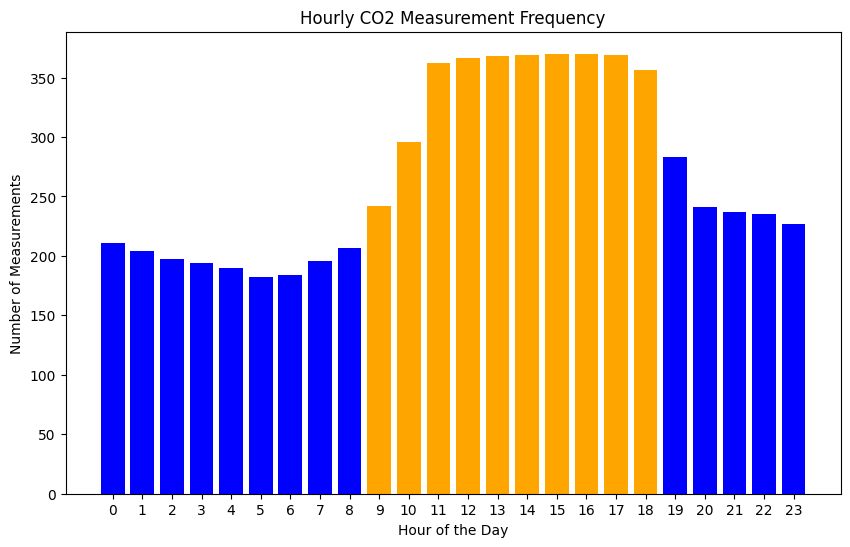

In [ ]:
# CO2 농도 데이터에서 결측값을 제거하고 시간대 추출
co2_data = data[['MSRM_DT', 'INNER_CBDX_CTRN']].dropna()
co2_data['Hour'] = co2_data['MSRM_DT'].dt.hour


# 시간대별 측정 횟수 계산
hourly_counts = co2_data['Hour'].value_counts().sort_index()

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(hourly_counts.index, hourly_counts.values, width=0.8, color='blue')

# 오전 9시부터 오후 6시 사이의 시간대는 주황색으로 강조
for hour in range(9, 19):
    plt.bar(hour, hourly_counts[hour], color='orange', width=0.8)

# 제목 및 라벨 추가
plt.title("Hourly CO2 Measurement Frequency")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Measurements")
plt.xticks(range(24), labels=[f"{i}" for i in range(24)])

plt.show()

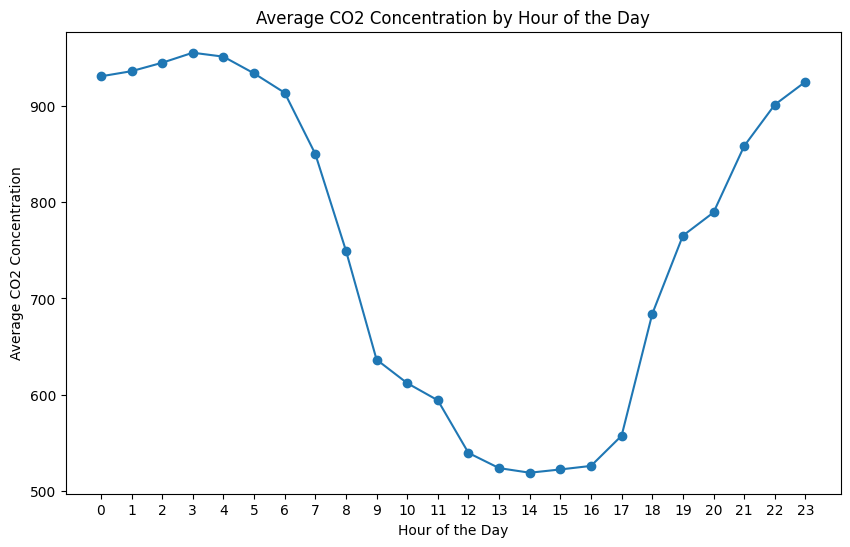

In [ ]:
# 시간대별 CO2 농도 평균 계산
hourly_pattern = co2_data.groupby(co2_data['MSRM_DT'].dt.hour)['INNER_CBDX_CTRN'].mean()

# 시간대별 패턴 시각화
plt.figure(figsize=(10, 6))
plt.plot(hourly_pattern.index, hourly_pattern.values, marker='o')

# 제목 및 라벨 추가
plt.title("Average CO2 Concentration by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Average CO2 Concentration")
plt.xticks(range(24), labels=[f"{i}" for i in range(24)])

plt.show()

In [ ]:
# INNER_CBDX_CTRN 열 분리
inner_cbdx_ctrn = data[['MSRM_DT', 'INNER_CBDX_CTRN']].copy()

# NaN 구간을 식별하고 각 NaN 구간의 길이를 계산
inner_cbdx_ctrn['NaN'] = inner_cbdx_ctrn['INNER_CBDX_CTRN'].isna().astype(int)
inner_cbdx_ctrn['NaN_Group'] = (inner_cbdx_ctrn['NaN'].diff(1) != 0).cumsum() * inner_cbdx_ctrn['NaN']
nan_gap_lengths = inner_cbdx_ctrn[inner_cbdx_ctrn['NaN'] == 1].groupby('NaN_Group').size()

# 결측 구간의 길이에 따라 단기/장기 구분 기준 설정 (예: 길이가 5 이하인 경우 단기)
threshold = 5

# 긴 결측 구간 - 앞뒤 채우기
long_gap_indices = nan_gap_lengths[nan_gap_lengths > threshold].index
for idx in long_gap_indices:
    inner_cbdx_ctrn.loc[inner_cbdx_ctrn['NaN_Group'] == idx, 'INNER_CBDX_CTRN'] = inner_cbdx_ctrn['INNER_CBDX_CTRN'].fillna(method='ffill').fillna(method='bfill')

# 단기 결측 구간 - 스플라인 보간
inner_cbdx_ctrn['INNER_CBDX_CTRN'] = inner_cbdx_ctrn['INNER_CBDX_CTRN'].interpolate(method='spline', order=3)

# 보완 작업 후 임시 열 삭제
inner_cbdx_ctrn = inner_cbdx_ctrn.drop(columns=['NaN', 'NaN_Group'])

inner_cbdx_ctrn


<ipython-input-13-002d9ba0c617>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inner_cbdx_ctrn.loc[inner_cbdx_ctrn['NaN_Group'] == idx, 'INNER_CBDX_CTRN'] = inner_cbdx_ctrn['INNER_CBDX_CTRN'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-13-002d9ba0c617>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inner_cbdx_ctrn.loc[inner_cbdx_ctrn['NaN_Group'] == idx, 'INNER_CBDX_CTRN'] = inner_cbdx_ctrn['INNER_CBDX_CTRN'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-13-002d9ba0c617>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inner_cbdx_ctrn.loc[inner_cbdx_ctrn['NaN_Group'] == idx, 'INNER_CBDX_CTRN'] = inner_cbdx_ctrn['INNER_CBDX_CTRN'].fillna(method='ffill').fillna(method='bfill')
<ipython-i

,MSRM_DT,INNER_CBDX_CTRN
0,2019-01-01 00:00:00,765.0
1,2019-01-01 01:00:00,765.0
2,2019-01-01 02:00:00,765.0
3,2019-01-01 03:00:00,765.0
4,2019-01-01 04:00:00,765.0
...,...,...
9067,2020-08-17 19:00:00,575.0
9068,2020-08-17 20:00:00,575.0
9069,2020-08-17 21:00:00,575.0
9070,2020-08-17 22:00:00,575.0


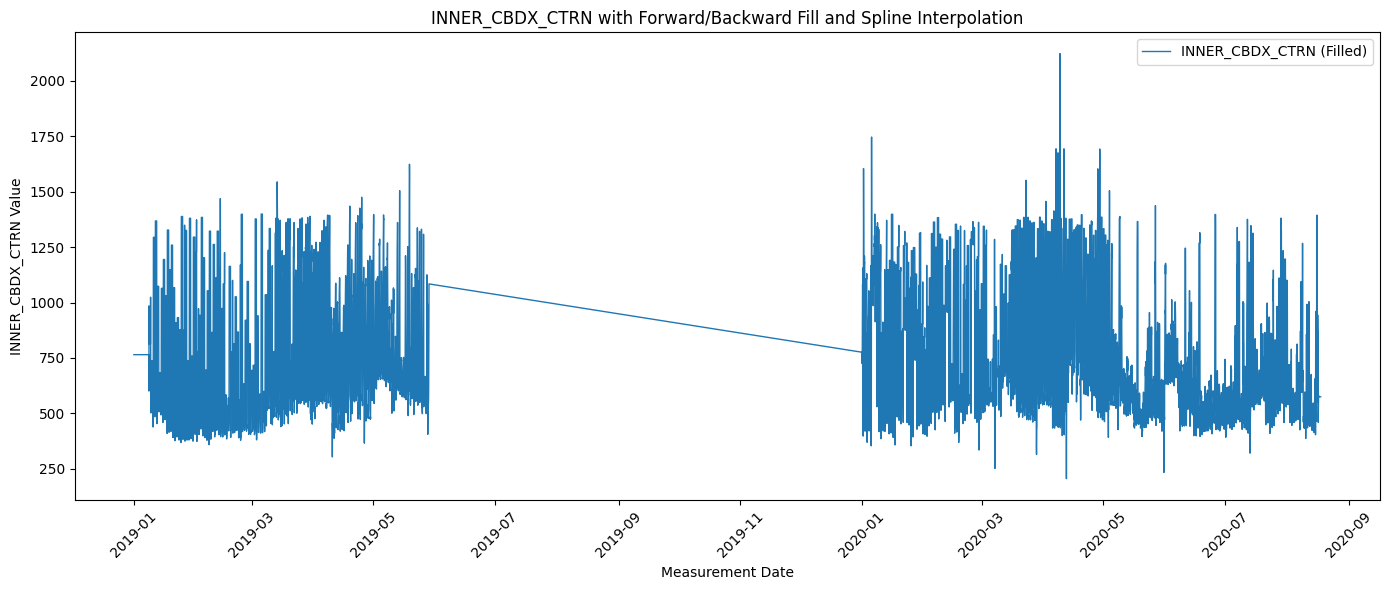

In [ ]:
# 데이터 시각화
plt.figure(figsize=(14, 6))
plt.plot(inner_cbdx_ctrn['MSRM_DT'], inner_cbdx_ctrn['INNER_CBDX_CTRN'], label='INNER_CBDX_CTRN (Filled)', linewidth=1)
plt.xlabel('Measurement Date')
plt.ylabel('INNER_CBDX_CTRN Value')
plt.title('INNER_CBDX_CTRN with Forward/Backward Fill and Spline Interpolation')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# `MSRM_DT` 열을 기준으로 원래 `data`와 보간된 `inner_cbdx_ctrn`를 병합
data['INNER_CBDX_CTRN'] = inner_cbdx_ctrn['INNER_CBDX_CTRN']

In [ ]:
data

,MSRM_DT,INNER_TPRT,INNER_HMDT,INNER_CBDX_CTRN,SHPMN_QTY
0,2019-01-01 00:00:00,19.1,87.0,765.0,NaN
1,2019-01-01 01:00:00,18.8,87.0,765.0,NaN
2,2019-01-01 02:00:00,18.5,87.0,765.0,NaN
3,2019-01-01 03:00:00,18.1,87.0,765.0,NaN
4,2019-01-01 04:00:00,17.8,88.0,765.0,NaN
...,...,...,...,...,...
9067,2020-08-17 19:00:00,NaN,NaN,575.0,270.0
9068,2020-08-17 20:00:00,NaN,NaN,575.0,270.0
9069,2020-08-17 21:00:00,NaN,NaN,575.0,270.0
9070,2020-08-17 22:00:00,NaN,NaN,575.0,270.0


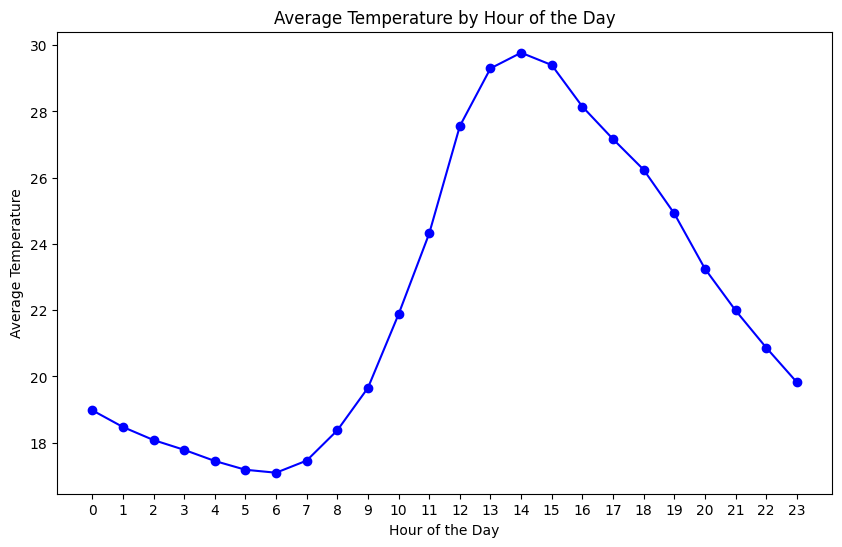

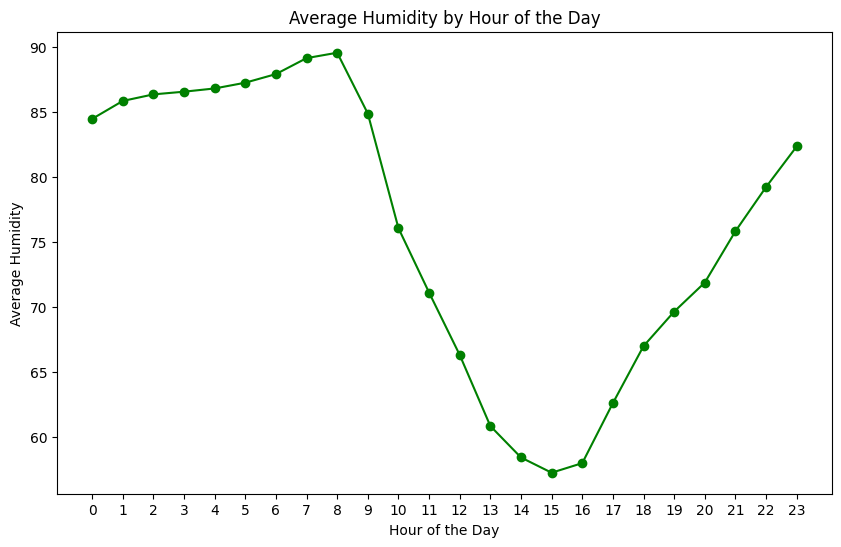

In [ ]:
# 시간대별 Temperature 평균 계산 및 시각화
temp_hourly_pattern = data.groupby(data['MSRM_DT'].dt.hour)['INNER_TPRT'].mean()

plt.figure(figsize=(10, 6))
plt.plot(temp_hourly_pattern.index, temp_hourly_pattern.values, marker='o', color='blue')

# 제목 및 라벨 추가
plt.title("Average Temperature by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Temperature")
plt.xticks(range(24), labels=[f"{i}" for i in range(24)])

plt.show()

# 시간대별 Humidity 평균 계산 및 시각화
humidity_hourly_pattern = data.groupby(data['MSRM_DT'].dt.hour)['INNER_HMDT'].mean()

plt.figure(figsize=(10, 6))
plt.plot(humidity_hourly_pattern.index, humidity_hourly_pattern.values, marker='o', color='green')

# 제목 및 라벨 추가
plt.title("Average Humidity by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Humidity")
plt.xticks(range(24), labels=[f"{i}" for i in range(24)])

plt.show()


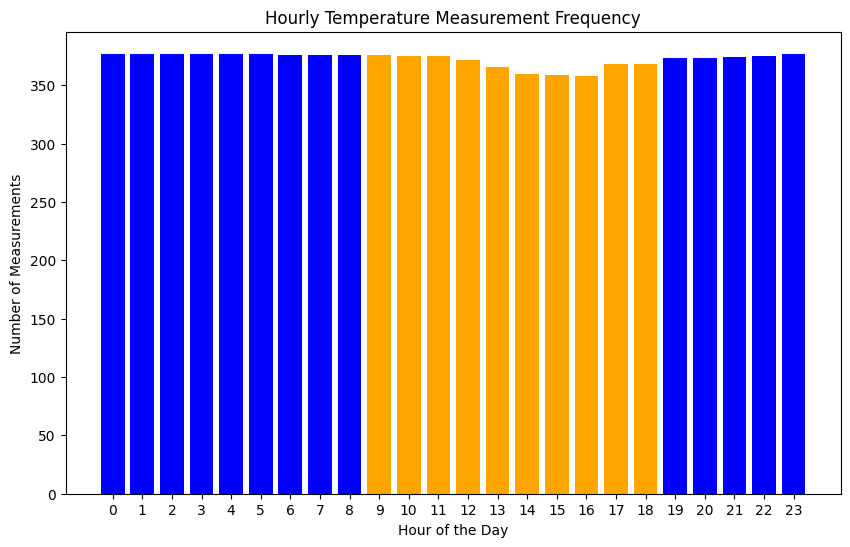

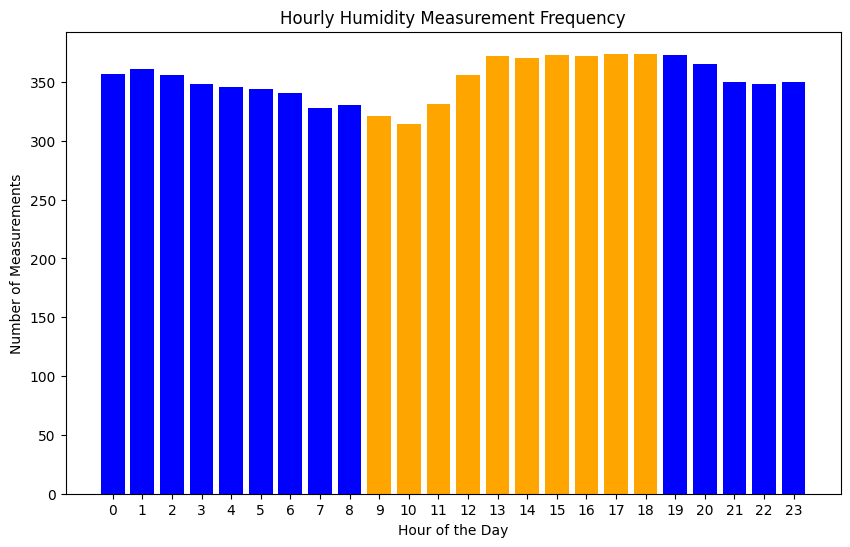

In [ ]:
import matplotlib.pyplot as plt

# INNER_TPRT에 대한 시간대별 측정 횟수 시각화
# 결측값 제거 및 시간대 추출
temp_data = data[['MSRM_DT', 'INNER_TPRT']].dropna()
temp_data['Hour'] = temp_data['MSRM_DT'].dt.hour

# 시간대별 측정 횟수 계산
temp_hourly_counts = temp_data['Hour'].value_counts().sort_index()

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(temp_hourly_counts.index, temp_hourly_counts.values, width=0.8, color='blue')

# 오전 9시부터 오후 6시 사이의 시간대는 주황색으로 강조
for hour in range(9, 19):
    if hour in temp_hourly_counts.index:
        plt.bar(hour, temp_hourly_counts[hour], color='orange', width=0.8)

# 제목 및 라벨 추가
plt.title("Hourly Temperature Measurement Frequency")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Measurements")
plt.xticks(range(24), labels=[f"{i}" for i in range(24)])

plt.show()

# INNER_HMDT에 대한 시간대별 측정 횟수 시각화
# 결측값 제거 및 시간대 추출
humidity_data = data[['MSRM_DT', 'INNER_HMDT']].dropna()
humidity_data['Hour'] = humidity_data['MSRM_DT'].dt.hour

# 시간대별 측정 횟수 계산
humidity_hourly_counts = humidity_data['Hour'].value_counts().sort_index()

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(humidity_hourly_counts.index, humidity_hourly_counts.values, width=0.8, color='blue')

# 오전 9시부터 오후 6시 사이의 시간대는 주황색으로 강조
for hour in range(9, 19):
    if hour in humidity_hourly_counts.index:
        plt.bar(hour, humidity_hourly_counts[hour], color='orange', width=0.8)

# 제목 및 라벨 추가
plt.title("Hourly Humidity Measurement Frequency")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Measurements")
plt.xticks(range(24), labels=[f"{i}" for i in range(24)])

plt.show()


In [ ]:
# 출하량 데이터 열 분리
shpmn_qty = data[['MSRM_DT', 'SHPMN_QTY']].copy()

# NaN 구간을 식별하고 각 NaN 구간의 길이를 계산
shpmn_qty['NaN'] = shpmn_qty['SHPMN_QTY'].isna().astype(int)
shpmn_qty['NaN_Group'] = (shpmn_qty['NaN'].diff(1) != 0).cumsum() * shpmn_qty['NaN']
nan_gap_lengths = shpmn_qty[shpmn_qty['NaN'] == 1].groupby('NaN_Group').size()

# 결측 구간의 길이에 따라 단기/장기 구분 기준 설정 (예: 길이가 5 이하인 경우 단기)
threshold = 5

# 긴 결측 구간 - 앞뒤 채우기
long_gap_indices = nan_gap_lengths[nan_gap_lengths > threshold].index
for idx in long_gap_indices:
    shpmn_qty.loc[shpmn_qty['NaN_Group'] == idx, 'SHPMN_QTY'] = shpmn_qty['SHPMN_QTY'].fillna(method='ffill').fillna(method='bfill')

# 단기 결측 구간 - 선형 보간
shpmn_qty['SHPMN_QTY'] = shpmn_qty['SHPMN_QTY'].interpolate(method='linear')

# 보완 작업 후 임시 열 삭제
shpmn_qty = shpmn_qty.drop(columns=['NaN', 'NaN_Group'])

# 보간된 출하량 데이터를 원래 데이터에 병합
data['SHPMN_QTY'] = shpmn_qty['SHPMN_QTY']

# 결과 확인
data


<ipython-input-19-23e2a45a72ea>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  shpmn_qty.loc[shpmn_qty['NaN_Group'] == idx, 'SHPMN_QTY'] = shpmn_qty['SHPMN_QTY'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-19-23e2a45a72ea>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  shpmn_qty.loc[shpmn_qty['NaN_Group'] == idx, 'SHPMN_QTY'] = shpmn_qty['SHPMN_QTY'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-19-23e2a45a72ea>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  shpmn_qty.loc[shpmn_qty['NaN_Group'] == idx, 'SHPMN_QTY'] = shpmn_qty['SHPMN_QTY'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-19-23e2a45a72ea>:15: FutureWarning: Series.fillna with 'method' is deprecated and wil

,MSRM_DT,INNER_TPRT,INNER_HMDT,INNER_CBDX_CTRN,SHPMN_QTY
0,2019-01-01 00:00:00,19.1,87.0,765.0,740.0
1,2019-01-01 01:00:00,18.8,87.0,765.0,740.0
2,2019-01-01 02:00:00,18.5,87.0,765.0,740.0
3,2019-01-01 03:00:00,18.1,87.0,765.0,740.0
4,2019-01-01 04:00:00,17.8,88.0,765.0,740.0
...,...,...,...,...,...
9067,2020-08-17 19:00:00,NaN,NaN,575.0,270.0
9068,2020-08-17 20:00:00,NaN,NaN,575.0,270.0
9069,2020-08-17 21:00:00,NaN,NaN,575.0,270.0
9070,2020-08-17 22:00:00,NaN,NaN,575.0,270.0


In [ ]:
# 출하량 데이터와 동일한 방식으로 각 열의 결측값 처리
def fill_missing_values(df, column_name, threshold=5):
    # NaN 구간을 식별하고 각 NaN 구간의 길이를 계산
    temp_df = df[['MSRM_DT', column_name]].copy()
    temp_df['NaN'] = temp_df[column_name].isna().astype(int)
    temp_df['NaN_Group'] = (temp_df['NaN'].diff(1) != 0).cumsum() * temp_df['NaN']
    nan_gap_lengths = temp_df[temp_df['NaN'] == 1].groupby('NaN_Group').size()

    # 긴 결측 구간 - 앞뒤 채우기
    long_gap_indices = nan_gap_lengths[nan_gap_lengths > threshold].index
    for idx in long_gap_indices:
        temp_df.loc[temp_df['NaN_Group'] == idx, column_name] = temp_df[column_name].fillna(method='ffill').fillna(method='bfill')

    # 단기 결측 구간 - 선형 보간
    temp_df[column_name] = temp_df[column_name].interpolate(method='linear')

    # 임시 열 삭제
    temp_df = temp_df.drop(columns=['NaN', 'NaN_Group'])

    return temp_df[column_name]

# 각 열에 대해 결측값 처리
data['INNER_TPRT'] = fill_missing_values(data, 'INNER_TPRT')
data['INNER_HMDT'] = fill_missing_values(data, 'INNER_HMDT')

# 결과 확인
data.head()


<ipython-input-20-218c86a46787>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_df.loc[temp_df['NaN_Group'] == idx, column_name] = temp_df[column_name].fillna(method='ffill').fillna(method='bfill')
<ipython-input-20-218c86a46787>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_df.loc[temp_df['NaN_Group'] == idx, column_name] = temp_df[column_name].fillna(method='ffill').fillna(method='bfill')
<ipython-input-20-218c86a46787>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_df.loc[temp_df['NaN_Group'] == idx, column_name] = temp_df[column_name].fillna(method='ffill').fillna(method='bfill')
<ipython-input-20-218c86a46787>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a futur

,MSRM_DT,INNER_TPRT,INNER_HMDT,INNER_CBDX_CTRN,SHPMN_QTY
0,2019-01-01 00:00:00,19.1,87.0,765.0,740.0
1,2019-01-01 01:00:00,18.8,87.0,765.0,740.0
2,2019-01-01 02:00:00,18.5,87.0,765.0,740.0
3,2019-01-01 03:00:00,18.1,87.0,765.0,740.0
4,2019-01-01 04:00:00,17.8,88.0,765.0,740.0


In [ ]:
data = data.round(2)
data

,MSRM_DT,INNER_TPRT,INNER_HMDT,INNER_CBDX_CTRN,SHPMN_QTY
0,2019-01-01 00:00:00,19.1,87.0,765.0,740.0
1,2019-01-01 01:00:00,18.8,87.0,765.0,740.0
2,2019-01-01 02:00:00,18.5,87.0,765.0,740.0
3,2019-01-01 03:00:00,18.1,87.0,765.0,740.0
4,2019-01-01 04:00:00,17.8,88.0,765.0,740.0
...,...,...,...,...,...
9067,2020-08-17 19:00:00,35.3,63.5,575.0,270.0
9068,2020-08-17 20:00:00,35.3,63.5,575.0,270.0
9069,2020-08-17 21:00:00,35.3,63.5,575.0,270.0
9070,2020-08-17 22:00:00,35.3,63.5,575.0,270.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# 병합된 데이터를 새로운 엑셀 파일로 저장
output_file_path = '/content/drive/MyDrive/2024빅데이터콘테스트/env_to_prod.xlsx'
data.to_excel(output_file_path, index=False)

print(f"env_to_prod.xlsx has been saved to {output_file_path}")


env_to_prod.xlsx has been saved to /content/drive/MyDrive/2024빅데이터콘테스트/env_to_prod.xlsx


# 최종 모델 선정 - RandomForest회귀 모델


*   고려사항
    - 랜덤 포레스트 모델은 비시계열 모델임 -> 시간 순서에 따른 특성을 직접 반영하지 않고 과거의 관측치를 특성으로 사용하여 다음 값을 예측하는 방식
    - 시계열 데이터를 고정된 길이의 입력 시퀀스로 변환하여 입력
        * MSRM_DT (측정일)에서 시간 정보를 추출해 추가 피처로 활용






* 가장 낮은 오차와 높은 결정 계수(R²)를 기록하여 가장 정확한 예측 성능을 보임
* 비선형 관계를 잘 학습


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
file_path = '/content/env_to_prod.xlsx'
df = pd.read_excel(file_path)

# 시간 피처 추가
df['hour'] = pd.to_datetime(df['MSRM_DT']).dt.hour
df['day'] = pd.to_datetime(df['MSRM_DT']).dt.day
df['month'] = pd.to_datetime(df['MSRM_DT']).dt.month

# 필요한 열 선택 및 결측값 제거
df = df[['SHPMN_QTY', 'hour', 'day', 'month']].dropna()

# 데이터 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['SHPMN_QTY']])  # SHPMN_QTY만 정규화

# 시계열 데이터셋 생성 함수 (n개의 이전 데이터를 사용해 다음 값을 예측)
def create_dataset(data, time_features, n_steps=24):
    X, y = [], []
    for i in range(len(data) - n_steps):
        # 이전 n_steps의 출하량 + 시간 피처 추가
        features = data[i:i + n_steps, 0].tolist()  # 출하량 데이터
        time_data = time_features[i + n_steps]      # 현재 시간 피처
        X.append(features + time_data.tolist())    # 출하량 + 시간 피처 결합
        y.append(data[i + n_steps, 0])             # 타겟 값
    return np.array(X), np.array(y)

# 시간 피처 준비
time_features = df[['hour', 'day', 'month']].values

# 데이터셋 생성
n_steps = 24
X, y = create_dataset(data_scaled, time_features, n_steps=n_steps)

# 훈련 및 테스트 데이터 분할 (80:20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
predictions = model.predict(X_test)

# 결과 역정규화
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 성능 평가
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print("평균 절대 오차 (MAE):", mae)
print("평균 제곱 오차 (MSE):", mse)
print("결정 계수 (R²):", r2)

# 예측값과 실제값 일부 비교
print("예측 출하량:", predictions_rescaled[:5])
print("실제 출하량:", y_test_rescaled[:5])

평균 절대 오차 (MAE): 57.94392265193351
평균 제곱 오차 (MSE): 10521.228193370154
결정 계수 (R²): 0.949691589722547
예측 출하량: [900.  900.  900.  899.5 899.2]
실제 출하량: [900. 900. 900. 900. 900.]


# 모델 선택 과정 - 추가사항

*   내부 환경 변수 (INNER_TPRT, INNER_HMDT, INNER_CBDX_CTRN)
*   예측 값: 출하량 (SHPMN_QTY)
*   시계열 데이터셋


1.   LSTM 모델
    * 시계열 데이터의 패턴을 학습하여 미래를 예측
    * 이전 시점의 정보를 기억하고 활용
    * 과적합 될 수 있음




2.   ARIMA 모델
    * 데이터의 계절성과 추세를 반영
    * 비선형 관계가 많은 데이터에서는 성능이 떨어짐
3.   RandomForest회귀 모델
    * 여러 결정 트리 결합하려 예측
    * 비선형 패턴 잘 반영하며, 과적합에 강함
    * 시계열 순서 정보를 직접 반응하지는 않음






LSTM 모델


*  성능이 잘 나오지 않음
    - LSTM 모델은 장기적 의존성 학습하는 데 효과적이지만 데이터셋은 시간 패턴이 짧고 반복적으로, 급격하게 변화함
    - 데이터의 양이 부족해서 과적합 가능성도 있음



In [ ]:
#LSTM 모델
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 불러오기
file_path = '/content/env_to_prod.xlsx'
df = pd.read_excel(file_path)

# 필요한 열 선택 및 결측값 제거
data = df[['INNER_TPRT', 'INNER_HMDT', 'INNER_CBDX_CTRN', 'SHPMN_QTY']].dropna()

# 데이터 정규화 (환경 변수와 출하량을 함께 정규화)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 데이터셋을 80:20으로 시간 순서에 따라 나누기
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

# 시계열 데이터셋 생성 (24시간 데이터를 사용하여 다음 출하량 예측)
sequence_length = 24  # 하루 단위 시계열
X_train, y_train = [], []
X_test, y_test = [], []

# 훈련 데이터셋 생성
for i in range(len(train_data) - sequence_length):
    X_train.append(train_data[i:i+sequence_length, :-1])  # 환경 변수
    y_train.append(train_data[i+sequence_length, -1])     # 출하량

# 테스트 데이터셋 생성
for i in range(len(test_data) - sequence_length):
    X_test.append(test_data[i:i+sequence_length, :-1])  # 환경 변수
    y_test.append(test_data[i+sequence_length, -1])     # 출하량

# 배열로 변환
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# LSTM 모델 구성
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# 모델 컴파일 및 학습 설정
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
epochs = 50
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 예측 및 역정규화
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(np.concatenate((test_data[sequence_length:, :-1], predictions), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((test_data[sequence_length:, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

# 모델 성능 평가 지표 계산
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print("평균 절대 오차 (MAE):", mae)
print("평균 제곱 오차 (MSE):", mse)
print("결정 계수 (R²):", r2)

# 예측 출하량과 실제 출하량 일부 비교
print("예측 출하량:", predictions_rescaled[:5].flatten())
print("실제 출하량:", y_test_rescaled[:5].flatten())


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0238 - val_loss: 0.0307
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0183 - val_loss: 0.0333
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0158 - val_loss: 0.0315
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0149 - val_loss: 0.0412
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0135 - val_loss: 0.0336
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0121 - val_loss: 0.0539
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0112 - val_loss: 0.0848
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0107 - val_loss: 0.0799
Epoch 9/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0100 - val_loss: 0.0791
Epoch 10/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0096 - val_loss: 0.0596
Epoch 11/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0107 - val_loss: 0.0526
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
평균 절대 오차 (MAE

ARIMA 모델


*   성능이 잘 나오지 않음 -
    - ARIMA 모델은 선형 모델이기 때문에 비선형적 패턴을 잘 설명하지 못함
    - 데이터셋은 비선형적


In [ ]:
#ARIMA 모델
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 데이터 불러오기
file_path = '/content/env_to_prod.xlsx'
df = pd.read_excel(file_path)

# 필요한 열 선택 및 결측값 제거
data = df[['SHPMN_QTY']].dropna()

# 훈련과 테스트 데이터 분할 (80:20)
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# ARIMA 모델 생성 및 학습 (p, d, q 값 조정 필요)
model = ARIMA(train_data, order=(5, 1, 0))  # (p=5, d=1, q=0) 예시 값입니다.
fitted_model = model.fit()

# 테스트 데이터로 예측 수행
forecast = fitted_model.forecast(steps=len(test_data))

# 성능 평가
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
r2 = r2_score(test_data, forecast)

print("평균 절대 오차 (MAE):", mae)
print("평균 제곱 오차 (MSE):", mse)
print("결정 계수 (R²):", r2)

# 예측값과 실제값 일부 비교
print("예측 출하량:", forecast[:5].values)
print("실제 출하량:", test_data[:5].values.flatten())

평균 절대 오차 (MAE): 388.3636363636364
평균 제곱 오차 (MSE): 220550.0826446281
결정 계수 (R²): -0.05733022777729824
예측 출하량: [900. 900. 900. 900. 900.]
실제 출하량: [900 900 900 900 900]




*   문제점
    - 데이터셋은 시계열이지만, 하루 주기 동안 짧고 급격한 비선형 변동을 보이는 패턴이 있으며 이런 겨우 LSTM 이나, ARIMA 모델의 특성과 맞지 않아 성능이 저하될 수 있다.



RandomForest회귀 모델


*   고려사항
    - 랜덤 포레스트 모델은 비시계열 모델임 -> 시간 순서에 따른 특성을 직접 반영하지 않고 과거의 관측치를 특성으로 사용하여 다음 값을 예측하는 방식
    - 시계열 데이터를 고정된 길이의 입력 시퀀스로 변환하여 입력
        * 시계열 데이터셋 생성 함수 사용
        * 과거 24시간의 데이터를 사용하여 다음 시간의 출하량을 예측하는 방식으로 데이터셋 생성


In [ ]:
#RandomForest회귀 모델
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
file_path = '/content/env_to_prod.xlsx'
df = pd.read_excel(file_path)

# 필요한 열 선택 및 결측값 제거
data = df[['SHPMN_QTY']].dropna()

# 데이터 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 시계열 데이터셋 생성 함수 (n개의 이전 데이터를 사용해 다음 값을 예측)
#X: 연속된 n_steps만큼의 데이터(24개의 이전 값)
#y: X 바로 다음 시간의 값
def create_dataset(data, n_steps=24):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps, 0]) # n개의 이전 데이터를 하나의 입력으로 사용
        y.append(data[i + n_steps, 0])     # n개의 이후 값을 타겟으로 설정
    return np.array(X), np.array(y)

# 데이터셋 생성 (24개 이전 데이터를 사용하여 다음 출하량 예측)
n_steps = 24
X, y = create_dataset(data_scaled, n_steps)

# 훈련 및 테스트 데이터 분할 (80:20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
predictions = model.predict(X_test)

# 결과 역정규화
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 성능 평가
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print("평균 절대 오차 (MAE):", mae)
print("평균 제곱 오차 (MSE):", mse)
print("결정 계수 (R²):", r2)

# 예측값과 실제값 일부 비교
print("예측 출하량:", predictions_rescaled[:5])
print("실제 출하량:", y_test_rescaled[:5])

평균 절대 오차 (MAE): 79.38317874484957
평균 제곱 오차 (MSE): 17610.060203068777
결정 계수 (R²): 0.9157955594704338
예측 출하량: [898.77029345 898.21712144 897.30451776 896.86989946 896.17735753]
실제 출하량: [900. 900. 900. 900. 900.]


# MSRM_DT (측정일)에서 시간 정보를 추출해 추가 피처로 활용

* 가장 낮은 오차와 높은 결정 계수(R²)를 기록하여 가장 정확한 예측 성능을 보임
* 비선형 관계를 잘 학습



In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
file_path = '/content/env_to_prod.xlsx'
df = pd.read_excel(file_path)

# 시간 피처 추가
df['hour'] = pd.to_datetime(df['MSRM_DT']).dt.hour
df['day'] = pd.to_datetime(df['MSRM_DT']).dt.day
df['month'] = pd.to_datetime(df['MSRM_DT']).dt.month

# 필요한 열 선택 및 결측값 제거
df = df[['SHPMN_QTY', 'hour', 'day', 'month']].dropna()

# 데이터 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['SHPMN_QTY']])  # SHPMN_QTY만 정규화

# 시계열 데이터셋 생성 함수 (n개의 이전 데이터를 사용해 다음 값을 예측)
def create_dataset(data, time_features, n_steps=24):
    X, y = [], []
    for i in range(len(data) - n_steps):
        # 이전 n_steps의 출하량 + 시간 피처 추가
        features = data[i:i + n_steps, 0].tolist()  # 출하량 데이터
        time_data = time_features[i + n_steps]      # 현재 시간 피처
        X.append(features + time_data.tolist())    # 출하량 + 시간 피처 결합
        y.append(data[i + n_steps, 0])             # 타겟 값
    return np.array(X), np.array(y)

# 시간 피처 준비
time_features = df[['hour', 'day', 'month']].values

# 데이터셋 생성
n_steps = 24
X, y = create_dataset(data_scaled, time_features, n_steps=n_steps)

# 훈련 및 테스트 데이터 분할 (80:20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
predictions = model.predict(X_test)

# 결과 역정규화
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 성능 평가
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print("평균 절대 오차 (MAE):", mae)
print("평균 제곱 오차 (MSE):", mse)
print("결정 계수 (R²):", r2)

# 예측값과 실제값 일부 비교
print("예측 출하량:", predictions_rescaled[:5])
print("실제 출하량:", y_test_rescaled[:5])

평균 절대 오차 (MAE): 57.94392265193351
평균 제곱 오차 (MSE): 10521.228193370154
결정 계수 (R²): 0.949691589722547
예측 출하량: [900.  900.  900.  899.5 899.2]
실제 출하량: [900. 900. 900. 900. 900.]


# Gradient Boosting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# 데이터 불러오기
file_path = '/content/env_to_prod.xlsx'
df = pd.read_excel(file_path)

# 시간 정보 추가
df['MSRM_DT'] = pd.to_datetime(df['MSRM_DT'])  # 날짜/시간 데이터 변환
df['TIME_INDEX'] = (df['MSRM_DT'] - df['MSRM_DT'].min()).dt.total_seconds()  # 시간 인덱스 생성

# 독립 변수와 종속 변수 선택
X = df[['INNER_TPRT', 'INNER_HMDT', 'INNER_CBDX_CTRN', 'TIME_INDEX']]  # 독립 변수
y = df['SHPMN_QTY']  # 종속 변수

# 결측값 제거
X = X.dropna()
y = y.loc[X.index]

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting Regressor 모델 생성 및 학습
gbr_model_time = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbr_model_time.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
gbr_predictions_time = gbr_model_time.predict(X_test)

# 성능 평가
gbr_mae_time = mean_absolute_error(y_test, gbr_predictions_time)
gbr_mse_time = mean_squared_error(y_test, gbr_predictions_time)
gbr_r2_time = r2_score(y_test, gbr_predictions_time)

# 결과 출력
print(f"평균 절대 오차 (MAE): {gbr_mae_time}")
print(f"평균 제곱 오차 (MSE): {gbr_mse_time}")
print(f"결정 계수 (R²): {gbr_r2_time}")

# 예측값과 실제값 일부 비교
print("예측값:", gbr_predictions_time[:5])
print("실제값:", y_test[:5].tolist())

평균 절대 오차 (MAE): 58.20568808113043
평균 제곱 오차 (MSE): 11522.551313764048
결정 계수 (R²): 0.9305410552783221
예측값: [ 733.67125033 1072.92326968 1747.213058    732.51760302  479.14691745]
실제값: [740, 1450, 1740, 740, 440]
